## Python imports

In [4]:
import sys
sys.path.append('../')
import artools

import scipy as sp
import scipy.integrate
import scipy.linalg

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ipywidgets
from IPython.display import display

## Define rate function

In [5]:
#2D van de Vusse kinetics
#A -> B -> C

def rate_fn(C,t):
    cA = C[0]
    cB = C[1]
    
    #rate constants
    k1 = 1.0;
    k2 = 1.0;
    k3 = 10.0;

    #r = [rA, rB]
    return sp.array([-k1*cA - 2*k3*cA**2,
                    k1*cA - k2*cB])

#Feed point and stoichiometry
stoich_mat = sp.array([[-1., 1, 0],
                      [0., -1, 1]]).T
Cf0 = sp.array([1., 0, 0])

#Determine stoichiometric subspace S
S_cs, S_es = artools.calc_stoich_subspace(stoich_mat, Cf0)

#PFR trajectory from the feed point as a test region
Cf = sp.array([Cf0[0], Cf0[1]])
pfr_ts = sp.logspace(-3, sp.log10(10), 100)
pfr_cs = scipy.integrate.odeint(rate_fn, Cf, pfr_ts)

## NOTE: Needs description of what is going on here...

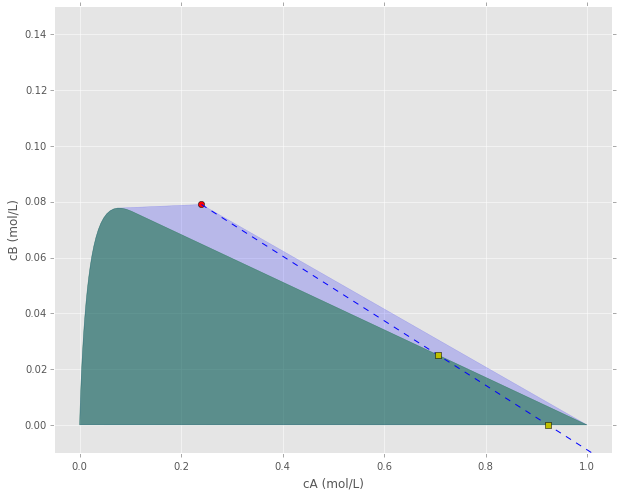

In [6]:
def plot_fn(xi=0.4, yi=0.1):
    
    ci = sp.array([xi, yi])
    ri = rate_fn(ci, 0)
    
    #compute polytope constraints
    all_cs = pfr_cs
    A,b = artools.vert2con(all_cs)
    P_cs = artools.con2vert(A, b)
    
    #plot
    fig = artools.plot_region2d(P_cs)
    ax = fig.gca()
    fig.hold(True)   

    #current point ci
    ax.plot(ci[0], ci[1], "ro")
    
    #backwards cstr line from ci
    zi = ci - 100.0*ri
    ax.plot((ci[0], zi[0]), (ci[1], zi[1]), "b--")

    #fig = artools.plot_Hplanes(A,b,fig)

    #Determine if the backwards CSTR line intersects the current region
    F = sp.dot(A, ci) - b
    G = sp.dot(A, ri)
    
    ts = F/G    
    for i,fi in enumerate(F):
        gi = G[i]

        if gi==0:
            continue

        ti = fi/gi

        if ti > 0.0:
            xi = ci - ti*ri
            #print xi, artools.inregion(xi, A, b)
            #ax.plot(xi[0], xi[1], 'g*')

            if artools.out_region(ci, A, b) and artools.in_region(xi, A, b):
                ax.plot(xi[0], xi[1], 'ys')
                #ax.set_title("Intersection!")
                
                tmp_Xs = sp.vstack([all_cs, ci])
                artools.plot_region2d(tmp_Xs, ax=ax, alpha=0.1, color="b")

    #set up figure display
    fig.set_figwidth(10)
    fig.set_figheight(8)
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.01, 0.15])

    ax.set_xlabel("cA (mol/L)")
    ax.set_ylabel("cB (mol/L)")
    
    plt.show(fig)
    
ipywidgets.interactive(plot_fn, xi=(0,1,0.01), yi=(0, 0.15, 0.001))